In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import geopandas as gpd
import pylab as pl
import os
import json
import fiona
import requests
import zipfile
import io
from shapely.geometry import Point
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIdata = os.getenv('PUIDATA')

In [3]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.urlretrieve(url, 'NYCPUMA.gz')
os.system('unzip NYCPUMA.gz -d' + PUIdata + '/NYCPUMA')

0

In [4]:
for file in os.listdir(PUIdata + '/NYCPUMA'):
    if 'shp' in file:
        shpfile = file
pumashp = gpd.GeoDataFrame.from_file(PUIdata + '/NYCPUMA/' + shpfile)

In [5]:
pumashp.head()

,shape_area,shape_leng,puma,geometry
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...


In [6]:
pumashp.crs

{'init': 'epsg:4326'}

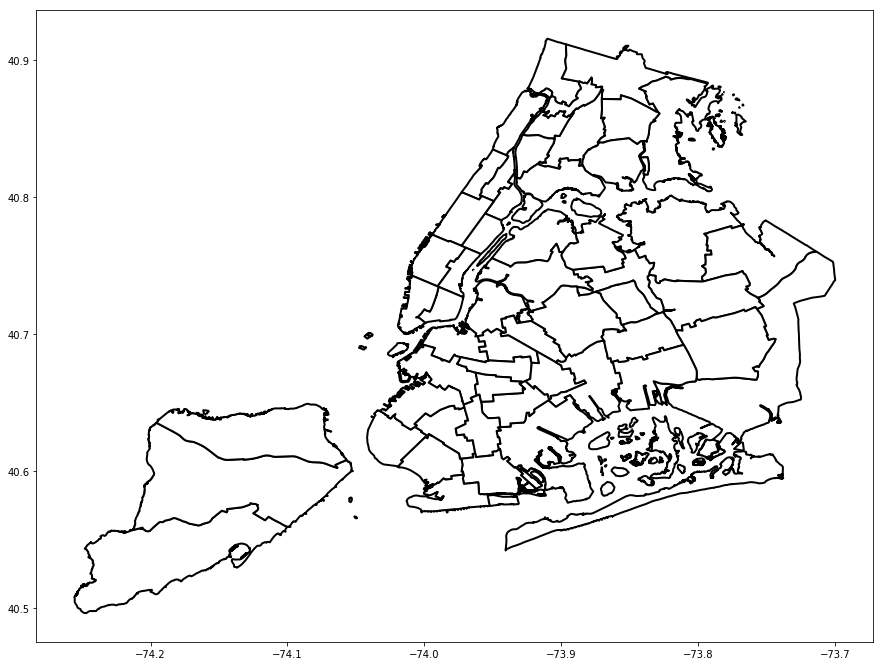

In [7]:
# using the built in plot function as pumashp.plot(pumashp....)
# using a choroplethNYC function that FBB wrote
pumashp.plot(color="white", edgecolor="black", lw=2,figsize = (15,15));

### Figure 1: NYC PUMA Regions Boundary

In [9]:
# import readline
# myAPI = PUIdata + '/myAPI.py'
# f = open(PUIdata + '/myAPI.py')
# myAPI = f.readline()

cens_key = open(os.getenv('PUIDATA')+'/census_key.txt', 'r+')
myAPI = cens_key.readlines()[0]


In [10]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [11]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [12]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [13]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [14]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [15]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [16]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content

pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [18]:
pumaBB = pumaBB.merge(pumaPP, on='public use microdata area')
pumaBB = pumaBB[['B28002_004E','NAME_x','state_x','public use microdata area','B28002_001E']]
pumaBB['pcBB'] = (pumaBB['B28002_004E']/pumaBB['B28002_001E'])*100
pumaBB.columns = ['B28002_004E','NAME', 'state', 'public use microdata area','B28002_001E','pcBB']
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [19]:
!ls $PUIDATA

201401-citibike-tripdata.csv
201401-citibike-tripdata.zip
201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201502-citibike-tripdata.csv
201502-citibike-tripdata.zip
201503-citibike-tripdata.csv
201503-citibike-tripdata.zip
201504-citibike-tripdata.csv
201504-citibike-tripdata.zip
201505-citibike-tripdata.csv
201505-citibike-tripdata.zip
201506-citibike-tripdata.csv
201506-citibike-tripdata.zip
201507-citibike-tripdata.csv
201507-citibike-tripdata.zip
201508-citibike-tripdata.csv
201508-citibike-tripdata.zip
201601-citibike-tripdata.csv
201601-citibike-tripdata.zip
201602-citibike-tripdata.csv
201602-citibike-tripdata.zip
201603-citibike-tripdata.csv
201603-citibike-tripdata.zip
201604-citibike-tripdata.csv
201604-citibike-tripdata.zip
201606-citibike-tripdata.csv
201606-citibike-tripdata.zip
201607-citibike-tripdata.csv
201607-citibike-tripdata.zip
201608-citibike-tripdata.csv
201608-citibike-tripdata.zip
201610-citibike-tripdata.csv
201610-citibike-tripdata.zip
201612-citibik

In [20]:
os.system('unzip ' + PUIdata + '/ACS_16_1YR_GCT2801.ST50.zip -d ' + PUIdata)

256

In [21]:
!ls $PUIDATA

201401-citibike-tripdata.csv
201401-citibike-tripdata.zip
201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201502-citibike-tripdata.csv
201502-citibike-tripdata.zip
201503-citibike-tripdata.csv
201503-citibike-tripdata.zip
201504-citibike-tripdata.csv
201504-citibike-tripdata.zip
201505-citibike-tripdata.csv
201505-citibike-tripdata.zip
201506-citibike-tripdata.csv
201506-citibike-tripdata.zip
201507-citibike-tripdata.csv
201507-citibike-tripdata.zip
201508-citibike-tripdata.csv
201508-citibike-tripdata.zip
201601-citibike-tripdata.csv
201601-citibike-tripdata.zip
201602-citibike-tripdata.csv
201602-citibike-tripdata.zip
201603-citibike-tripdata.csv
201603-citibike-tripdata.zip
201604-citibike-tripdata.csv
201604-citibike-tripdata.zip
201606-citibike-tripdata.csv
201606-citibike-tripdata.zip
201607-citibike-tripdata.csv
201607-citibike-tripdata.zip
201608-citibike-tripdata.csv
201608-citibike-tripdata.zip
201610-citibike-tripdata.csv
201610-citibike-tripdata.zip
201612-citibik

In [22]:
bbpc = pd.read_csv(PUIdata + '/ACS_16_1YR_GCT2801.ST50_with_ann.csv',
            skiprows=1, usecols=['Target Geo Id2', 'Percent', 'Margin of Error'])
bbpc.columns = ['gid', 'HC01', 'HC02']
bbpc.head()

,gid,HC01,HC02
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [23]:
bbpc['gid'] = bbpc['gid'] - 3600000
bbpc.head()

,gid,HC01,HC02
0,-3599999,74.7,0.5
1,-3499900,70.9,2.5
2,-3499800,80.5,2.7
3,-3499699,87.0,2.8
4,-3499698,81.9,2.9


In [24]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


In [25]:
#choropleth of the percentage of internet access
pumashp['puma'] = pumashp['puma'].astype(integer)

# merge pumashp shapefile
BBshp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area')

Text(0.5,1,'Percentage of Households with Broadband Access')

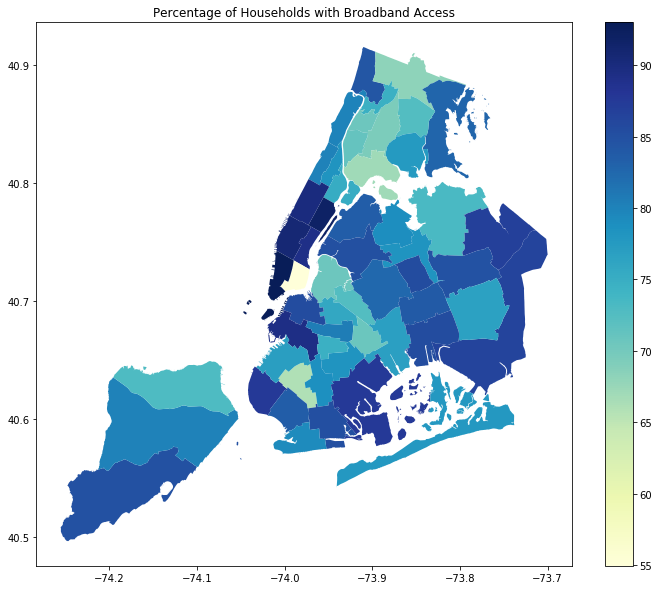

In [26]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111)
BBshp.plot(ax=ax, column='pcBB',cmap='YlGnBu',legend=True)
ax.set_title("Percentage of Households with Broadband Access")


## Figure 2: Choropleth of the percentage of households with broadband access
From this figure, we can tell that downtown Manhattan has very high percentage, whereas Bronx has much lower ones.

In [27]:
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv')
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [28]:
linkNYC.drop('Unnamed: 0', axis=1, inplace=True)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [29]:
linkNYC.shape

(1414, 4)

In [30]:
linkNYC["geometry"] = linkNYC.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
# Convert to a GeoDataFrame
linkNYC = gpd.GeoDataFrame(linkNYC, geometry="geometry")
# set crs
linkNYC.crs = {'init': 'epsg:4326'}
linkNYC.head()

,link_site,longitude,date_link_,latitude,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,POINT (-73.953439 40.728133)


Text(0.5,1,'Location of LinkNYC stations on map of percentage of Households with Broadband Access')

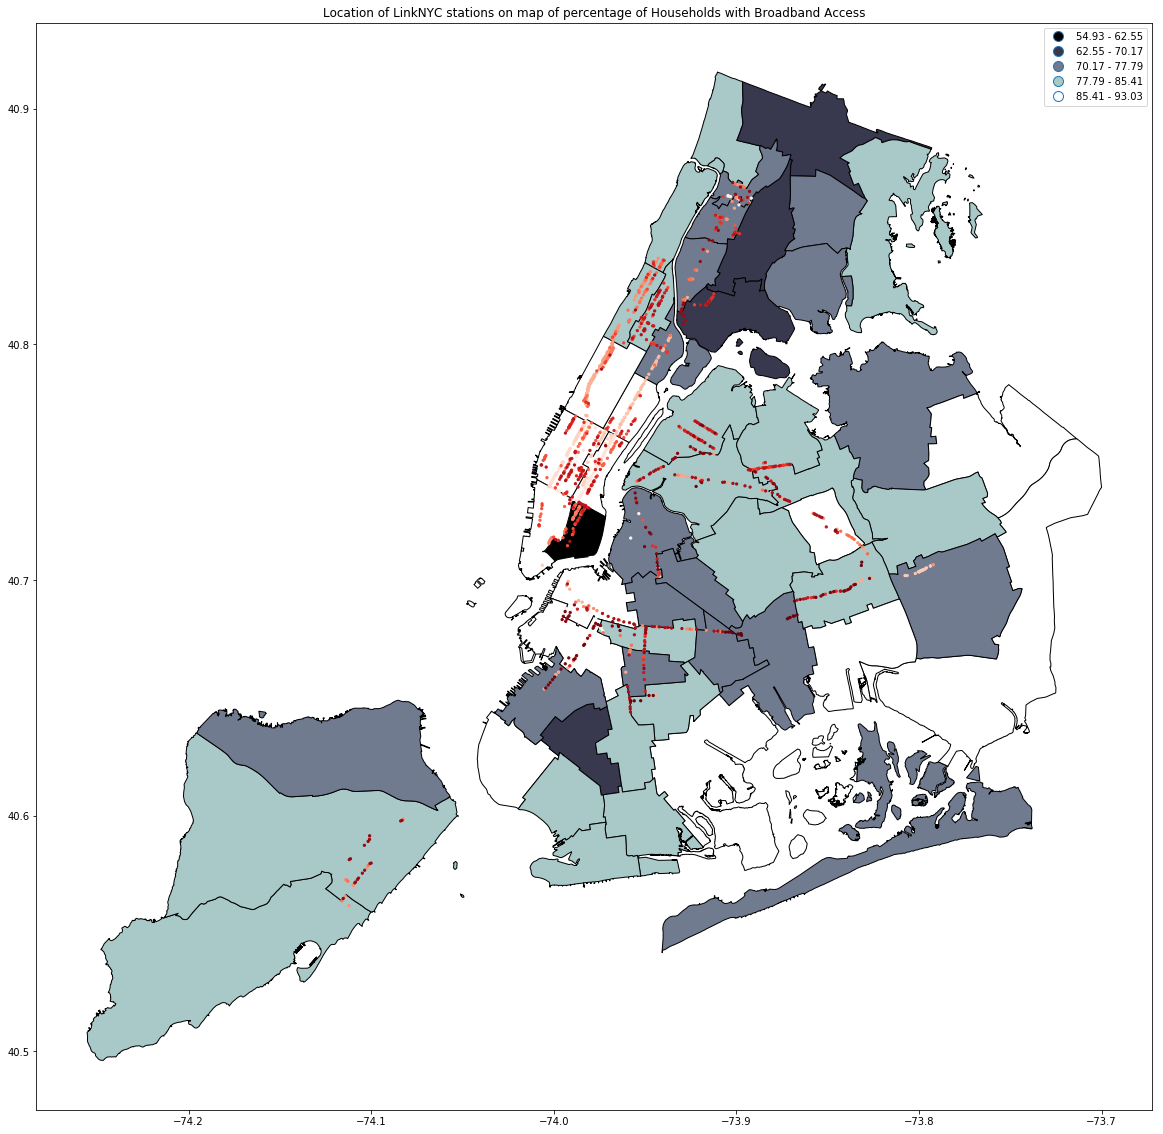

In [31]:
# plot the choropleth of the percentage of households with broadband access
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
BBshp.plot(ax=ax, column='pcBB',scheme='Equal_interval', k=5, cmap='bone', edgecolor='k', legend=True)

# plot linkNYC stations
linkNYC.plot(ax=ax, c=linkNYC.date_link_, cmap='Reds', markersize=5)
ax.set_title("Location of LinkNYC stations on map of percentage of Households with Broadband Access")

## Figure 3: location of the linkNYC stations on top of a choropleth of broadband access percentage
this figure shows that Manhattan overall has more linkNYC stations compared to other boroughs, it seems that most linkNYC stations are located within high Households with Broadband Access percentage areas, especially in Midtown area. Meanwhile, in Bronx where less percenge covered areas, almost no linkNYC stations.


In [32]:
#set keyword for total population
keyPOP = 'B00001_001E'

#getting total population
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [33]:
# merge into the geodataframe
pop_shp = BBshp.merge(pumaPop, on='public use microdata area')
pop_shp.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME_x,state_x,public use microdata area,B28002_001E,pcBB,B00001_001E,NAME_y,state_y,Unnamed: 4
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN


In [34]:
# convert crs
pop_shp.to_crs(epsg=2263, inplace=True)
linkNYC.to_crs(epsg=2263, inplace=True)

In [35]:
#create geodataframe with spatial join; count number of linkNYC in each PUMA
pjoin = gpd.sjoin(pop_shp, linkNYC, how='left')
pjoin = pjoin.groupby('puma').count()
pjoin = pjoin['link_site'].reset_index()
pjoin.head()

,puma,link_site
0,3701,1
1,3702,0
2,3703,0
3,3704,0
4,3705,1


In [36]:
# merge back into pumashp
pumashplc = pop_shp.merge(pjoin, on='puma')
pumashplc.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME_x,state_x,public use microdata area,B28002_001E,pcBB,B00001_001E,NAME_y,state_y,Unnamed: 4,link_site
0,9.792852e+07,53227.144357,3701,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,1
1,1.889860e+08,106050.002507,3702,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,0
2,2.670137e+08,304070.209400,3703,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,0
3,1.062129e+08,47970.901277,3704,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,0
4,1.224950e+08,68630.512052,3705,"POLYGON ((1015377.269592287 238959.501403747, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN,1


In [37]:
#linkNYC per 100 inhabitants
pumashplc['linkNYCp100p'] = (pumashplc['link_site']/pumashplc['B00001_001E'])*100
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

Text(0.5,1,'LinkNYC locations on map of number of stations per 100 people')

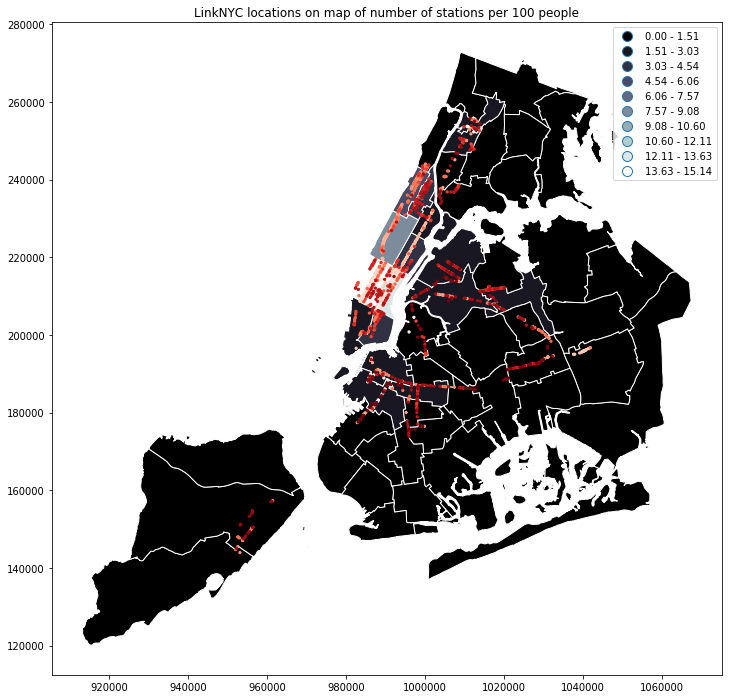

In [38]:
# plot the choropleth of the percentage of households with broadband access
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
pumashplc.plot(ax=ax, column='linkNYCp100p',scheme='Equal_interval', k=10, cmap='bone', edgecolor='w', legend=True)

# plot linkNYC stations
linkNYC.plot(ax=ax, c=linkNYC.date_link_, cmap='Reds', markersize=5)
ax.set_title("LinkNYC locations on map of number of stations per 100 people")

## Fig.4 linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

This figure shows us that majority of the locations in the city have less than 2 stations per 100 people, except midtown and downtown manhattan.

## Extra Credit

Text(0.5,1,'Histogram of number of stations per 100 people')

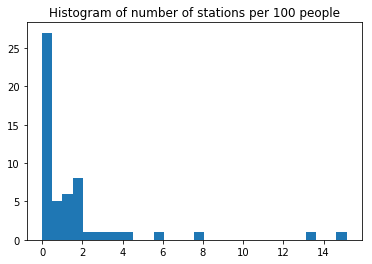

In [39]:
pl.hist(pumashplc["linkNYCp100p"], bins=30);
pl.title('Histogram of number of stations per 100 people')

Text(0.5,1,'LinkNYC locations on map of number of stations per 100 people in quantiles')

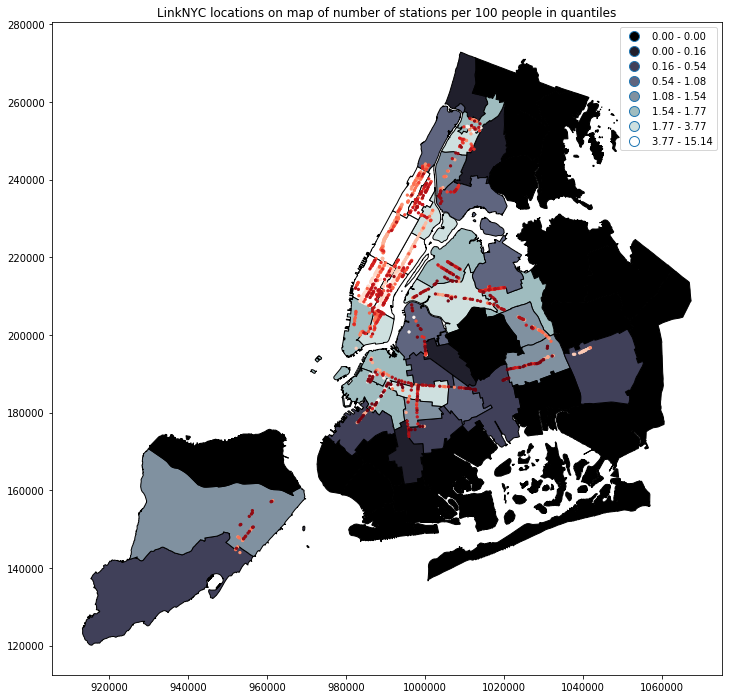

In [40]:
# plot the choropleth of the percentage of households with broadband access
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
pumashplc.plot(ax=ax, column='linkNYCp100p',scheme='quantiles', k=10, cmap='bone', edgecolor='black', legend=True)

# plot linkNYC stations
linkNYC.plot(ax=ax, c=linkNYC.date_link_, cmap='Reds', markersize=5);
ax.set_title("LinkNYC locations on map of number of stations per 100 people in quantiles")

### Figure 5: Locations of LinkNYC Stations on Choropleth of Number of Stations per 100 people in quantiles

In [41]:
#Export Shapefile
path = os.getenv('PUIDATA') + '/linkNYCpp.shp'
pumashplc.to_file(path)

In [42]:
import pysal as ps

#Spatial Weights - Contiguity: Queen Weights
qW_CT=ps.queen_from_shapefile(path)
#matrix of weights
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [43]:
#change the matrix to be row standard
qW_CT.transform = 'r'

In [44]:
#Spatial Lag
SpatialLag=ps.lag_spatial(qW_CT, pumashplc.linkNYCp100p)

In [45]:
#creating quantiles for mapping
SpatialLagQ5 = ps.Quantiles(SpatialLag, k=5)
SpatialLagQ5

              Quantiles               
 
Lower          Upper             Count
        x[i] <= 0.211               11
0.211 < x[i] <= 0.578               11
0.578 < x[i] <= 0.989               11
0.989 < x[i] <= 2.997               11
2.997 < x[i] <= 9.704               11

Text(0.5,1,'LinkNYC per person Spatial Lag Deciles')

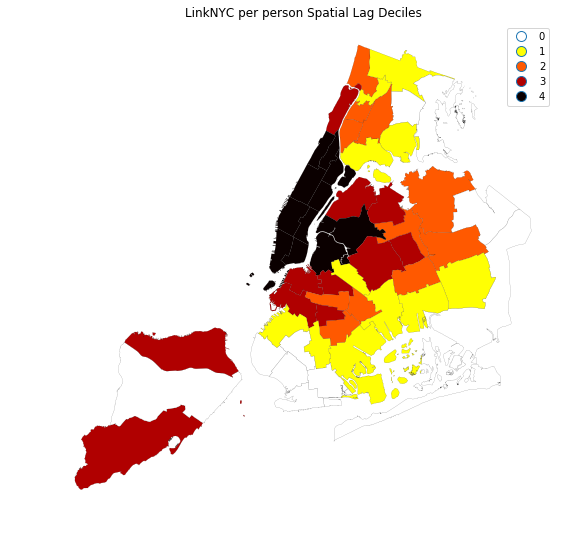

In [46]:
#map spatial lag
f, ax = plt.subplots(figsize=(9, 9))
pumashplc.assign(cl=SpatialLagQ5.yb).plot(column='cl', categorical=True, 
        k=5, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("LinkNYC per person Spatial Lag Deciles")

Grade: 10/10